In [1]:
print("Hello, World!")

Hello, World!


Found 800 files belonging to 2 classes.
Using 640 files for training.
Found 800 files belonging to 2 classes.
Using 160 files for validation.
52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Starting initial training with EfficientNetV2B3...
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.6141 - loss: 0.6471 - val_accuracy: 0.7188 - val_loss: 0.6055
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 884ms/step - accuracy: 0.7797 - loss: 0.4832 - val_accuracy: 0.7063 - val_loss: 0.5839
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 915ms/step - accuracy: 0.8313 - loss: 0.4001 - val_accuracy: 0.7375 - val_loss: 0.5608
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 907ms/step - accuracy: 0.8562 - loss: 0.3723 - val_accuracy: 0.7563 - val_loss: 0.5397
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 900ms/step - accuracy: 0.8687 - loss: 0.3556 - val_accuracy: 0.7500 - val_loss: 0.5461
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 904ms/step - accuracy: 0.8781 - loss: 0.3304 - val_accuracy: 0.7937 - va

C:\Users\susha\AppData\Local\Temp\ipykernel_17720\1257622881.py:121: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_true.append(int(labels.numpy()))



Classification Report:
              precision    recall  f1-score   support

      normal       0.83      0.90      0.86        84
   pneumonia       0.88      0.79      0.83        76

    accuracy                           0.85       160
   macro avg       0.85      0.85      0.85       160
weighted avg       0.85      0.85      0.85       160

Generating Confusion Matrix...


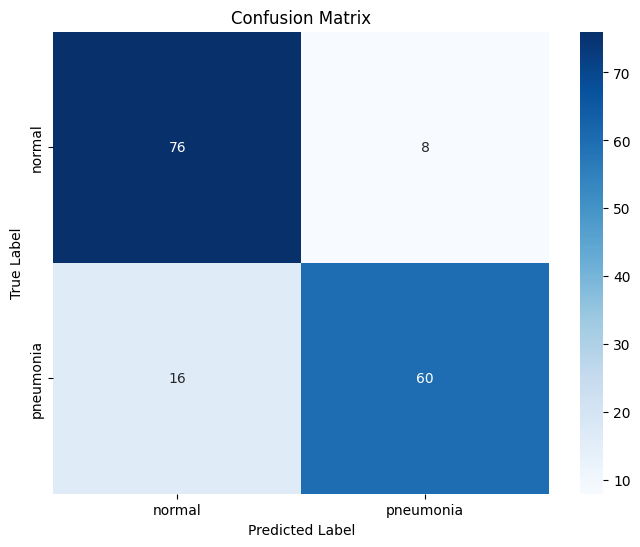


--- Saving and Testing Single Image ---
Model saved successfully as pneumonia_detector.keras


FileNotFoundError: [Errno 2] No such file or directory: '/content/chest_xray_data/normal/00630.jpg'

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import unittest
from IPython.display import Image, display

# =====================================================================
# SECTION 1: SETUP AND DATA LOADING
# =====================================================================
DATA_DIR = "chest_xray_data"
IMAGE_SIZE = (260, 260)
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.2

train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# =====================================================================
# SECTION 2: MODEL BUILDING, TRAINING, AND FINE-TUNING
# =====================================================================
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.2),
    ]
)

preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input
base_model = tf.keras.applications.EfficientNetV2B3(
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), include_top=False, weights="imagenet"
)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

# --- Initial Training ---
model.compile(
    optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"]
)
print("Starting initial training with EfficientNetV2B3...")
EPOCHS = 10
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS)

# --- Fine-Tuning ---
base_model.trainable = True
for layer in base_model.layers[:-60]:
    layer.trainable = False

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)

print("\nStarting fine-tuning...")
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True
)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=2
)

fine_tune_epochs = 25
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset,
    callbacks=[early_stopping, lr_scheduler],
)

print("\nTraining process complete!")
loss, accuracy = model.evaluate(validation_dataset)
print(f"Final Validation Accuracy: {accuracy * 100:.2f}%")

# =====================================================================
# SECTION 3: BLACK BOX TESTING (CONFUSION MATRIX & REPORT) ⬛
# This section evaluates the final trained model on the validation set.
# =====================================================================
print("\n--- Starting Black Box Testing ---")
y_true = []
y_pred = []

for images, labels in validation_dataset.unbatch():
    prediction = model.predict(tf.expand_dims(images, axis=0), verbose=0)
    y_true.append(int(labels.numpy()))
    y_pred.append(1 if prediction[0][0] > 0.5 else 0)

class_names = ["normal", "pneumonia"]
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("Generating Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# =====================================================================
# SECTION 4: SAVE MODEL AND TEST A SINGLE IMAGE
# This section saves the final model and then uses it for a single prediction.
# =====================================================================
print("\n--- Saving and Testing Single Image ---")
model.save("pneumonia_detector.keras")
print("Model saved successfully as pneumonia_detector.keras")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

Raw prediction score for the single test image: 0.0278
🩺 Diagnosis: Normal


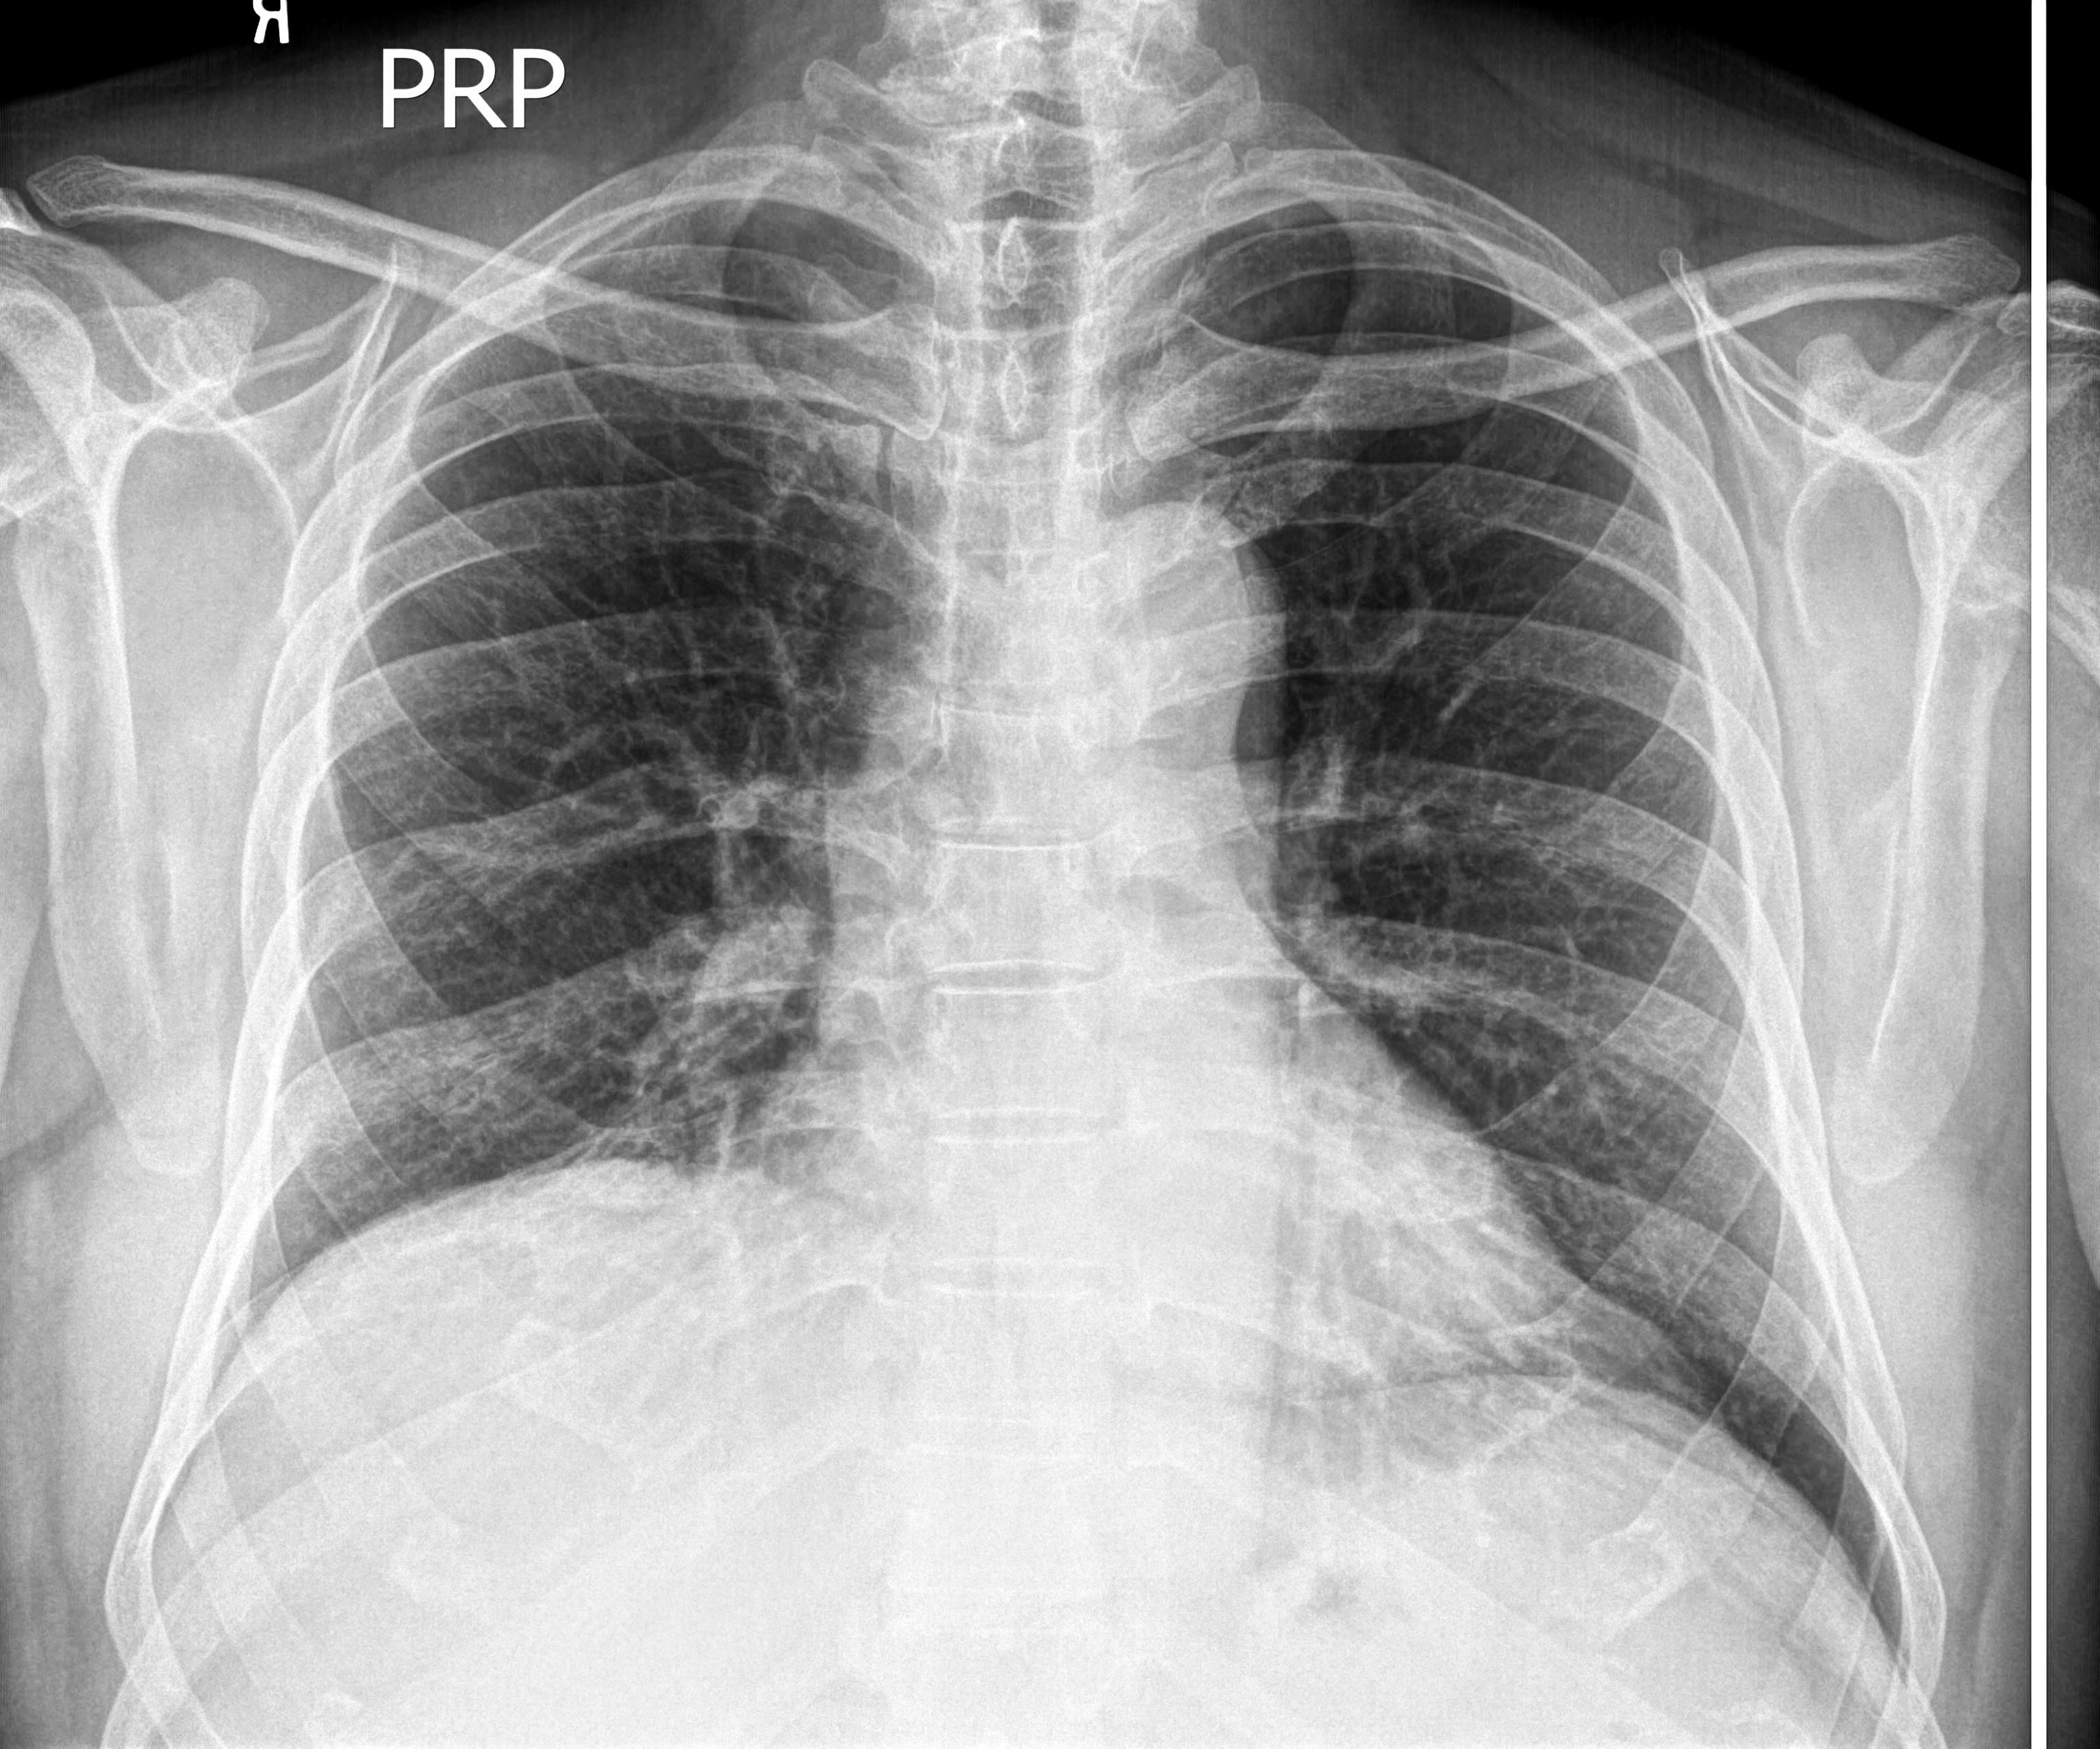

C:\Users\susha\AppData\Local\Temp\ipykernel_17720\800599942.py:54: DeprecationWarning: unittest.makeSuite() is deprecated and will be removed in Python 3.13. Please use unittest.TestLoader.loadTestsFromTestCase() instead.
  suite.addTest(unittest.makeSuite(TestImagePreprocessing))
..
----------------------------------------------------------------------
Ran 2 tests in 0.037s

OK



--- Starting White Box Testing ---
Running unit tests...
✅ Unit tests passed successfully.


In [5]:
# For this test, we use the 'model' object already in memory.
# In a real application, you would load it using: tf.keras.models.load_model('pneumonia_detector.keras')
image_path = "chest_xray_data/normal/00630.jpg"
img = tf.keras.utils.load_img(image_path, target_size=IMAGE_SIZE)
img_array = tf.keras.utils.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)

prediction = model.predict(img_preprocessed)
score = prediction[0][0]

print(f"\nRaw prediction score for the single test image: {score:.4f}")
if score > 0.5:
    print("🩺 Diagnosis: Pneumonia")
else:
    print("🩺 Diagnosis: Normal")

display(Image(filename=image_path, width=300))

# =====================================================================
# SECTION 5: WHITE BOX TESTING (UNIT TEST EXAMPLE) ⬜
# This section defines and runs a unit test for a component in isolation.
# =====================================================================
print("\n--- Starting White Box Testing ---")


def preprocess_for_unittesting(image_array):
    """A simplified function to be unit tested."""
    if not isinstance(image_array, np.ndarray):
        raise TypeError("Input must be a NumPy array")

    image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32)
    resized_image = tf.image.resize(image_tensor, IMAGE_SIZE)
    img_batch = np.expand_dims(resized_image, axis=0)
    return img_batch


class TestImagePreprocessing(unittest.TestCase):
    def test_output_shape(self):
        """Test if the function produces the correct output shape."""
        dummy_image = np.random.rand(100, 150, 3)
        processed_image = preprocess_for_unittesting(dummy_image)
        self.assertEqual(processed_image.shape, (1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    def test_input_type_error(self):
        """Test if it raises a TypeError for invalid input."""
        with self.assertRaises(TypeError):
            preprocess_for_unittesting("this is not an array")


# Run the unit tests
print("Running unit tests...")
suite = unittest.TestSuite()
suite.addTest(unittest.makeSuite(TestImagePreprocessing))
runner = unittest.TextTestRunner()
result = runner.run(suite)
if result.wasSuccessful():
    print("✅ Unit tests passed successfully.")